# A Simple Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled dataset.

In [2]:
!pip install -r requirements.txt | grep -v "already"

In [2]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) # auto restart kernel

{'status': 'ok', 'restart': True}

In [1]:
import numpy as np
import pandas as pd
import torch
from torchvision import datasets
import torchvision.transforms as T
import multiprocessing
from tqdm import tqdm

# helpers
from helpers import (get_data_loaders, seed_all)

# Ensure reproducability
seed_all(seed=42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10 examples for testing


### Visualize the Data

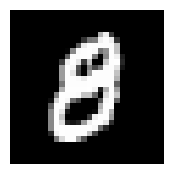

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch
dataiter = iter(data_loaders['train'])
images, labels = next(dataiter)
images = images.numpy()

# Get one image from the batch
# images[0], images[0].shape, images[0].ndim
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize=(2, 2))
sub.imshow(img, cmap='gray')
_ = sub.axis('off')

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into vectors of length 784. The images from this dataset are already normalized such that the values are between 0 and 1.Sd a simple autoen archcoder. 

The encoder and decoder should be made of simple Multi-Layer Perceptrons. The units that connect the encoder and decoder will be the _compressed representation_ (also called _embedding_).

Since the images are normalized between we d 1, you will need to use a **sigmoid activation on the output layer** to get values that match this input valueWexercise you are going to use a dimension for the embeddings of 32.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Define NN Architecture
class AutoEncoder(nn.Module):

    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()

        ## encoder ##
        # MLP with input size 28x28, output size encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(in_features=256, out_features=encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim),
        )

        ## decoder ##
        self.decoder = nn.Sequential(
            nn.Linear(in_features=encoding_dim, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(in_features=256, out_features=28*28),
            nn.Sigmoid()
        )

        self.autoencoder = nn.Sequential(
            nn.Flatten(),
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feed-forward behaviour
        # and scale the *output* layer with a sigmoid activation function
        encoded = self.autoencoder(x)

        # Reshape the output as an image
        # the shape should be (batch_size, channel_count, height, width)
        return encoded.reshape(encoded.shape[0], 1, 28, 28)


# Initialize the NN
encoding_dim = 32
model = AutoEncoder(encoding_dim)
if torch.cuda.is_available():
    model.cuda()

In [5]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=784, bias=True)
    (4): Sigmoid()
  )
  (autoencoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Linear(in_features=256, out_features=32, bias=True)
      (4): ReLU()


In [6]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
            Linear-3                  [-1, 256]         200,960
              ReLU-4                  [-1, 256]               0
              ReLU-5                  [-1, 256]               0
       BatchNorm1d-6                  [-1, 256]             512
       BatchNorm1d-7                  [-1, 256]             512
            Linear-8                   [-1, 32]           8,224
            Linear-9                   [-1, 32]           8,224
             ReLU-10                   [-1, 32]               0
             ReLU-11                   [-1, 32]               0
      BatchNorm1d-12                   [-1, 32]              64
      BatchNorm1d-13                   [-1, 32]              64
           Linear-14                  [

---
## Loss Function
We will use se the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [7]:
criterion = nn.MSELoss()

## Optimizer

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

## Training

The training loop is similar to a normal training loop, however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

In [9]:
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # set to training mode
    model.train()
        
    ###################
    # train the model #
    ###################
    
    # monitor training loss
    train_loss = 0.
    
    for data in tqdm(
        desc="Training",
        total=len(data_loaders['train']),
        iterable=data_loaders['train'],
        ncols=80,
    ):
        # disregard labels -> _
        images, _ = data
        if torch.cuda.is_available():
            images = images.cuda()

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # Calculate the loss (between output and input instead of "labels/targets")
        loss = criterion(outputs.flatten(), images.flatten())

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * images.size(0)

    ###################
    #   Validation    #
    ###################
    # monitor validation loss
    val_loss = 0.
    with torch.no_grad():
        for data in tqdm(
            desc="Validating",
            total=len(data_loaders['val']),
            iterable=data_loaders['val'],
            ncols=80,  
        ):
            # disregard labels -> _
            images, _ = data
            if torch.cuda.is_available():
                images = images.cuda()

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)

            # Calculate the loss (between output and input instead of "labels/targets")
            loss = criterion(outputs.flatten(), images.flatten())

            # Update running validation loss
            val_loss += loss.item() * images.size(0)

    # Print avg training statistics 
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['val'])

    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch: 1 	Training Loss: 58.138537	Valid Loss: 31.390722


Validating: 100%|███████████████████████████████| 12/12 [00:13<00:00,  1.12s/it]


Epoch: 2 	Training Loss: 27.254392	Valid Loss: 22.846437


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.11it/s]


Epoch: 3 	Training Loss: 21.134707	Valid Loss: 18.517307


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch: 4 	Training Loss: 17.240428	Valid Loss: 15.365045


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.30it/s]


Epoch: 5 	Training Loss: 14.527420	Valid Loss: 13.362886


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 6 	Training Loss: 12.843224	Valid Loss: 12.088553


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 7 	Training Loss: 11.775808	Valid Loss: 11.296294


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.29it/s]


Epoch: 8 	Training Loss: 11.056461	Valid Loss: 10.716177


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.27it/s]


Epoch: 9 	Training Loss: 10.559689	Valid Loss: 10.203606


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 10 	Training Loss: 10.039101	Valid Loss: 9.691781


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 11 	Training Loss: 9.657993	Valid Loss: 9.493472


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 12 	Training Loss: 9.249842	Valid Loss: 9.015205


Validating: 100%|███████████████████████████████| 12/12 [00:10<00:00,  1.14it/s]


Epoch: 13 	Training Loss: 8.901024	Valid Loss: 8.986780


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch: 14 	Training Loss: 8.722645	Valid Loss: 8.478968


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 15 	Training Loss: 8.459555	Valid Loss: 8.315363


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 16 	Training Loss: 8.280913	Valid Loss: 8.447551


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 17 	Training Loss: 8.120321	Valid Loss: 8.129892


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 18 	Training Loss: 8.060010	Valid Loss: 8.319733


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 19 	Training Loss: 8.009518	Valid Loss: 8.034884


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 20 	Training Loss: 7.880298	Valid Loss: 7.933388


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 21 	Training Loss: 7.854605	Valid Loss: 7.916101


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 22 	Training Loss: 7.751107	Valid Loss: 7.945728


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 23 	Training Loss: 7.797861	Valid Loss: 7.951730


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 24 	Training Loss: 7.609475	Valid Loss: 7.616573


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 25 	Training Loss: 7.587267	Valid Loss: 7.480736


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 26 	Training Loss: 7.491342	Valid Loss: 7.413296


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 27 	Training Loss: 7.321323	Valid Loss: 7.363833


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 28 	Training Loss: 7.226991	Valid Loss: 7.630296


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 29 	Training Loss: 7.219831	Valid Loss: 7.148285


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 30 	Training Loss: 7.111612	Valid Loss: 7.146843


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 31 	Training Loss: 6.991662	Valid Loss: 7.002075


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 32 	Training Loss: 7.032791	Valid Loss: 7.175152


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch: 33 	Training Loss: 7.008408	Valid Loss: 7.342382


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.31it/s]


Epoch: 34 	Training Loss: 7.049790	Valid Loss: 7.126736


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 35 	Training Loss: 6.965312	Valid Loss: 7.218203


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.33it/s]


Epoch: 36 	Training Loss: 6.838730	Valid Loss: 6.926942


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 37 	Training Loss: 6.893787	Valid Loss: 6.981691


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 38 	Training Loss: 6.891105	Valid Loss: 7.039480


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 39 	Training Loss: 6.807544	Valid Loss: 6.974291


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch: 40 	Training Loss: 6.804589	Valid Loss: 6.947637


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch: 41 	Training Loss: 6.731888	Valid Loss: 6.928944


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 42 	Training Loss: 6.674274	Valid Loss: 6.742896


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Epoch: 43 	Training Loss: 6.861020	Valid Loss: 7.191996


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 44 	Training Loss: 6.712422	Valid Loss: 6.741435


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.38it/s]


Epoch: 45 	Training Loss: 6.611104	Valid Loss: 6.786834


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 46 	Training Loss: 6.645408	Valid Loss: 6.915473


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 47 	Training Loss: 6.591982	Valid Loss: 6.716091


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.37it/s]


Epoch: 48 	Training Loss: 6.642480	Valid Loss: 6.925700


Validating: 100%|███████████████████████████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch: 49 	Training Loss: 6.569583	Valid Loss: 6.638215


Validating: 100%|███████████████████████████████| 12/12 [00:08<00:00,  1.34it/s]

Epoch: 50 	Training Loss: 6.537961	Valid Loss: 6.788415


## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [26]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(
        desc="Testing",
        total=len(data_loaders['test']),
        iterable=data_loaders['test'],
        ncols=80,  
    ):
        # disregard labels -> _
        images, _ = data
        if torch.cuda.is_available():
            images = images.cuda()

        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # Calculate the loss (between output and input instead of "labels/targets")
        loss = loss_no_reduction(outputs, images)
        
        # Accumulate results per-example
        for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
            losses[idx + i] = {
                'loss': float(l.cpu().numpy()),
                'image': images[i].cpu().numpy(),
                'reconstructed': outputs[i].cpu().numpy()
            }

        idx += loss.shape[0]
        
# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()
        

Testing: 100%|██████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


,loss,image,reconstructed
0,0.005403,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00063480873, 0.0013636247, 0.0005085095, ..."
1,0.009877,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00031515013, 0.0016229856, 0.0009725884, ..."
2,0.003008,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0013418869, 0.0016492341, 0.001286064, 0...."
3,0.007917,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0014731811, 0.002438784, 0.0020305591, 0...."
4,0.008114,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0022291497, 0.002851981, 0.0020182088, 0...."
